In [1]:
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [3]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report

import numpy as np
import cv2

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

import platform
import psutil

import random
import glob
from tqdm import tqdm
from tqdm.notebook import tqdm

import PIL
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import ImageEnhance, ImageOps, ImageFilter
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw

from tabulate import tabulate
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### Seed Value

In [4]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

### Dataset

In [5]:
root_dir = "/content/drive/MyDrive/Colab Notebooks/betel-leaf/betel_leaf_rezised_dataset"

file_paths = []
labels = []

for class_name in os.listdir(root_dir):
    class_dir = os.path.join(root_dir, class_name)
    if os.path.isdir(class_dir):
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)

df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Bacterial Leaf Disease, Count: 250
Class: Fungal Brown Spot Disease, Count: 250
Class: Healthy Leaf, Count: 231
Class: Dried Leaf, Count: 109


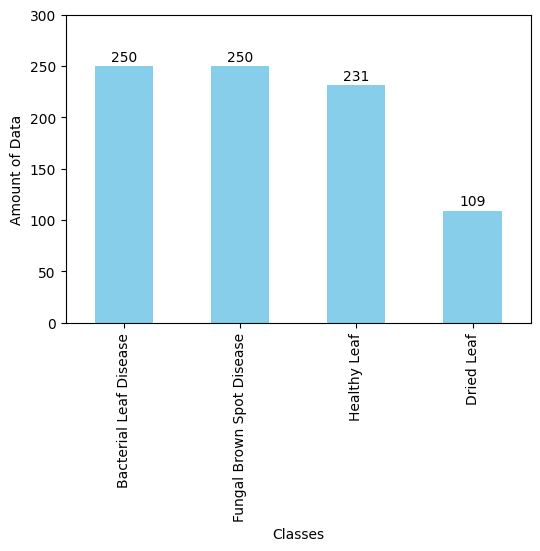

In [6]:
class_counts_df = df['label'].value_counts()

for class_name, count in class_counts_df.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_df.plot(kind='bar', color='skyblue')

plt.xlabel('Classes')
plt.ylabel('Amount of Data')
plt.xticks(rotation=90)

for i, count in enumerate(class_counts_df):
    ax.text(i, count + 5, str(count), ha='center')

plt.ylim(0, max(class_counts_df) * 1.2)
plt.show()

### Sample Image

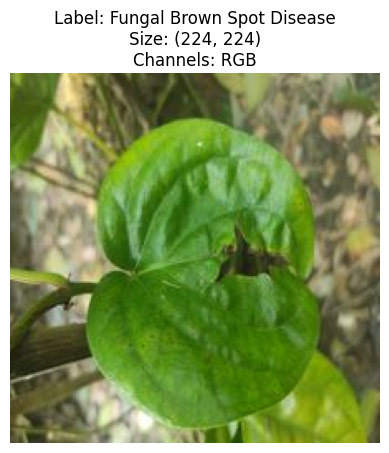

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)

size = image.size
channels = 'Grayscale' if image.mode == 'L' else 'RGB'
plt.title(f"Label: {label}\nSize: {size}\nChannels: {channels}")
plt.imshow(image)
plt.axis('off')
plt.show()

### Dataset Splits

In [6]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.2, random_state=42)
test_dataframe, valid_dataframe = train_test_split(temp_dataframe, test_size=0.5, random_state=42)
ulb_dataframe, lb_dataframe = train_test_split(train_dataframe, test_size=0.3, random_state=42)

In [9]:
print("Unlabeled Data: ", len(ulb_dataframe))
print("Labeled Data: ", len(lb_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_dataframe))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Unlabeled Data:  470
Labeled Data:  202
Validation Data:  84
Test Data:  84
-------------------------------------------
Total amounts of data in the dataset:  840


In [10]:
class_counts_lb = lb_dataframe['label'].value_counts()
class_counts_ulb = ulb_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()
class_counts_test = test_dataframe['label'].value_counts()

lb_table_data = [[class_name, count] for class_name, count in class_counts_lb.items()]
ulb_table_data = [[class_name, count] for class_name, count in class_counts_ulb.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]
test_table_data = [[class_name, count] for class_name, count in class_counts_test.items()]

print("Labeled Dataset")
print(tabulate(lb_table_data, headers=["Class", "Count"]))
print("\nUnlabeled Dataset")
print(tabulate(ulb_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))
print("\nTest Dataset")
print(tabulate(test_table_data, headers=["Class", "Count"]))

Labeled Dataset
Class                        Count
-------------------------  -------
Bacterial Leaf Disease          62
Healthy Leaf                    59
Fungal Brown Spot Disease       53
Dried Leaf                      28

Unlabeled Dataset
Class                        Count
-------------------------  -------
Fungal Brown Spot Disease      144
Bacterial Leaf Disease         143
Healthy Leaf                   120
Dried Leaf                      63

Validation Dataset
Class                        Count
-------------------------  -------
Fungal Brown Spot Disease       32
Healthy Leaf                    24
Bacterial Leaf Disease          21
Dried Leaf                       7

Test Dataset
Class                        Count
-------------------------  -------
Healthy Leaf                    28
Bacterial Leaf Disease          24
Fungal Brown Spot Disease       21
Dried Leaf                      11


### Device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Variables

In [8]:
total_class = 4
threshold_value = 0.80

### Batch Sizes

In [9]:
mu = 4
lb_batch = 8
ulb_batch = mu*lb_batch
val_batch = 8
print("Batch Size of Labeled Data: ", lb_batch)
print("Batch Size of Unlabeled Data: ", lb_batch,"x",mu, " = ", ulb_batch)
print("Batch Size of Validation Data: ", val_batch)

Batch Size of Labeled Data:  8
Batch Size of Unlabeled Data:  8 x 4  =  32
Batch Size of Validation Data:  8


### Checkpoint

In [10]:
save_path_checkpoints = "/content/drive/MyDrive/Colab Notebooks/betel-leaf/ablation/outputs"
os.makedirs(save_path_checkpoints, exist_ok=True)

### Dataset Class, Dataloader and Augmentations

In [11]:
class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, dataframe, weak_transform, strong_transform, normalize, is_lb=False):
        self.dataframe = dataframe
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(self.weak_transform(image)), label
        else:
            weak_image = self.weak_transform(image)
            strong_image = self.strong_transform(image)
            return self.normalize(weak_image), self.normalize(strong_image)

In [12]:
class ImageDatasetNoAugmentation(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Bacterial Leaf Disease': 0, 'Dried Leaf': 1, 'Fungal Brown Spot Disease': 2, 'Healthy Leaf': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
def train_data_transfrom():

    def ShearX(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


    def ShearY(img, v):  # [-0.3, 0.3]
        assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v = -v
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


    def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[0]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


    def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
        assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v = -v
        v = v * img.size[1]
        return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


    def Rotate(img, v):  # [-30, 30]
        assert -30 <= v <= 30
        if random.random() > 0.5:
            v = -v
        return img.rotate(v)


    def AutoContrast(img, _):
        return PIL.ImageOps.autocontrast(img)


    def Invert(img, _):
        return PIL.ImageOps.invert(img)


    def Equalize(img, _):
        return PIL.ImageOps.equalize(img)


    def Solarize(img, v):  # [0, 256]
        assert 0 <= v <= 256
        inverted_v = 256 - v
        return PIL.ImageOps.solarize(img, inverted_v)


    def Posterize(img, v):  # [4, 8]
        v = int(v)
        v = max(1, v)
        return PIL.ImageOps.posterize(img, v)


    def Contrast(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        enhanced_v = 1.9 - v + 0.1
        return PIL.ImageEnhance.Contrast(img).enhance(enhanced_v)


    def Color(img, v):
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Color(img).enhance(v)


    def Brightness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        v = 1.9 - v
        return PIL.ImageEnhance.Brightness(img).enhance(v)


    def Sharpness(img, v):  # [0.1,1.9]
        assert 0.1 <= v <= 1.9
        return PIL.ImageEnhance.Sharpness(img).enhance(v)


    def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
        # assert 0 <= v <= 20
        if v < 0:
            return img
        w, h = img.size
        x0 = np.random.uniform(w)
        y0 = np.random.uniform(h)

        x0 = int(max(0, x0 - v / 2.))
        y0 = int(max(0, y0 - v / 2.))
        x1 = min(w, x0 + v)
        y1 = min(h, y0 + v)

        xy = (x0, y0, x1, y1)
        color = (125, 123, 114)
        # color = (0, 0, 0)
        img = img.copy()
        PIL.ImageDraw.Draw(img).rectangle(xy, color)
        return img


    def Cutout(img, v):  # [0, 60] => percentage: [0, 0.2]
        assert 0.0 <= v <= 0.3
        if v <= 0.:
            return img

        v = v * img.size[0]
        return CutoutAbs(img, v)


    def Identity(img, v):
        return img


    def augment_list():
        aug_list = [
            (AutoContrast, 0, 1),
            (Equalize, 0, 1),
            (Invert, 0, 1),
            (Rotate, 0, 30),
            (Posterize, 0, 4),
            (Solarize, 0, 256),
            (Color, 0.1, 1.9),
            (Contrast, 0.1, 1.9),
            (Brightness, 0.1, 1.9),
            (Sharpness, 0.1, 1.9),
            (ShearX, 0.0, 0.3),
            (ShearY, 0.0, 0.3),
            (Cutout, 0, 0.3),
            (TranslateX, 0.0, 0.33),
            (TranslateY, 0.0, 0.33),
            (Identity, 0, 1)
        ]

        return aug_list


    class RandAugment:
        def __init__(self, n, m):
            self.n = n
            self.m = m      # [0, 30]
            self.augment_list = augment_list()

        def __call__(self, img):
            ops = random.choices(self.augment_list, k=self.n)
            for op, minval, maxval in ops:
                val = (float(self.m) / 30) * float(maxval - minval) + minval
                img = op(img, val)

            return img


    strong_transform = transforms.Compose([
        RandAugment(n=4, m=10)
    ])

    weak_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAffine(degrees=0, translate=(0.125, 0.125)),
    ])

    normalize = transforms.Compose([
            transforms.ToTensor()])

    ulb_dataset = ImageDatasetWithAugmentation (
        ulb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=False
    )

    lb_dataset = ImageDatasetWithAugmentation(
        lb_dataframe,
        weak_transform,
        strong_transform,
        normalize,
        is_lb=True
    )

    dataloader_ulb_dataset = DataLoader(ulb_dataset, batch_size = ulb_batch, shuffle=True, num_workers=2)
    dataloader_lb_dataset = DataLoader(lb_dataset, batch_size = lb_batch, shuffle=True, num_workers=2)

    return dataloader_ulb_dataset, dataloader_lb_dataset

dataloader_ulb_dataset, dataloader_lb_dataset = train_data_transfrom()

In [14]:
def valid_data_transfrom():

    normalize = transforms.Compose([
            transforms.ToTensor()])

    valid_dataset = ImageDatasetNoAugmentation(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDatasetNoAugmentation(
        test_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_valid_dataset, dataloader_test_dataset

dataloader_valid_dataset, dataloader_test_dataset = valid_data_transfrom()

### Neural Network

In [15]:
learning_rate = 0.0001

model = models.densenet201(weights=models.DenseNet201_Weights.DEFAULT)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
summary(model, input_size=(lb_batch, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:01<00:00, 54.4MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [8, 4]                    --
├─Sequential: 1-1                        [8, 1920, 7, 7]           --
│    └─Conv2d: 2-1                       [8, 64, 112, 112]         9,408
│    └─BatchNorm2d: 2-2                  [8, 64, 112, 112]         128
│    └─ReLU: 2-3                         [8, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                    [8, 64, 56, 56]           --
│    └─_DenseBlock: 2-5                  [8, 256, 56, 56]          --
│    │    └─_DenseLayer: 3-1             [8, 32, 56, 56]           45,440
│    │    └─_DenseLayer: 3-2             [8, 32, 56, 56]           49,600
│    │    └─_DenseLayer: 3-3             [8, 32, 56, 56]           53,760
│    │    └─_DenseLayer: 3-4             [8, 32, 56, 56]           57,920
│    │    └─_DenseLayer: 3-5             [8, 32, 56, 56]           62,080
│    │    └─_DenseLayer: 3-6             [8, 32, 56, 56]     

# FixMatch Training

##### FixMatch Implementation

In [16]:
def train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold):
    model.train()

    losses = []
    correct_predictions = 0
    total_samples = 0

    pbar = tqdm(dataloader_lb_dataset)

    ulb_iter = iter(dataloader_ulb_dataset)

    for batch_lb in pbar:
        model.zero_grad()

        # labelled data
        x_lb, y = batch_lb
        x_lb, y = x_lb.to(device), y.to(device)

        # unlabelled data
        try:
            x_weak, x_strong = next(ulb_iter)
        except StopIteration:
            ulb_iter = iter(dataloader_ulb_dataset)
            x_weak, x_strong = next(ulb_iter)

        x_weak, x_strong = x_weak.to(device), x_strong.to(device)

        # concat all x
        all_x = torch.cat([x_lb, x_weak, x_strong], dim=0)

        # compute logits
        all_logits = model(all_x)

        # logits and loss for labelled data
        logits_lb = all_logits[:x_lb.size(0)]
        loss_lb = F.cross_entropy(logits_lb, y)

        # logits for unlabelled data
        logits_ulb = all_logits[x_lb.size(0):]
        logits_weak, logits_strong = torch.chunk(logits_ulb, 2, dim=0)

        # stop gradient for weak augmented
        logits_weak = logits_weak.detach()

        # compute class probabilities
        probs_weak = F.softmax(logits_weak, dim=1)

        # compute pseudo labels (torch.max outputs the maximum values and the argmax)
        max_prob, pseudo_label = torch.max(probs_weak, dim=1)

        # mask for confident predictions
        mask = (max_prob > threshold).float()

        # mask non-confident prediction
        pseudo_label = pseudo_label.masked_fill(mask == 0, 0)

        # unsupervised loss by ignoring non-confident prediction
        loss_ulb = F.cross_entropy(logits_strong, pseudo_label, ignore_index=-1)

        # total loss
        loss = loss_lb + loss_ulb

        # compute accuracy for labeled data
        _, predicted = torch.max(logits_lb, 1)
        correct_predictions += (predicted == y).sum().item()
        total_samples += y.size(0)

        loss.backward()
        optimizer.step()

        loss_item = loss.item()
        losses.append(loss_item)

        pbar.set_description(f'train loss = {np.array(losses).mean():.3f}, accuracy = {correct_predictions / total_samples:.3f}')

        # fig, axes = plt.subplots(1, 10, figsize=(6, 4))
        # for i, ax in enumerate(axes.flat):
        #     ax.imshow(x_strong[i].cpu().permute(1, 2, 0))
        #     ax.axis('off')
        #     # ax.set_title(f'Label: {y[i].item()}')
        # plt.show()

    return np.array(losses).mean(), correct_predictions / total_samples

##### Validation

In [17]:
def validate(model, dataloader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    val_losses = []

    with torch.no_grad():
        for batch in dataloader:
            x_val, y_val = batch
            x_val, y_val = x_val.to(device), y_val.to(device)

            logits_val = model(x_val)
            loss_val = F.cross_entropy(logits_val, y_val)

            _, predicted_val = torch.max(logits_val, 1)
            correct_predictions += (predicted_val == y_val).sum().item()
            total_samples += y_val.size(0)

            val_losses.append(loss_val.item())

    accuracy = correct_predictions / total_samples
    val_loss = np.array(val_losses).mean()

    return accuracy, val_loss

##### Training

In [22]:
import time
start_time = time.time()

num_epochs = 25
early_stopping_rounds = 5
total_iterations = 0

num_epochs_without_improvement = 0
num_epochs_loss_greater = 0

losses = []
accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
prev_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_fixMatch(model, optimizer, dataloader_lb_dataset, dataloader_ulb_dataset, device, threshold=threshold_value)
    val_accuracy, val_loss = validate(model, dataloader_valid_dataset, device)

    losses.append(train_loss)
    accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs} - '
          f'Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f} - '
          f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}')

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        filepath = f"{save_path_checkpoints}/fm_lb30_th80.pt"
        checkpoint = {
            "epoch": epoch + 1,
            "model_weight": model.state_dict(),
            "optimizer_state": optimizer.state_dict()
        }
        torch.save(checkpoint, filepath)
        print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_accuracy:.3f}")

    if val_loss > train_loss:
        num_epochs_loss_greater += 1
    else:
        num_epochs_loss_greater = 0

    if num_epochs_loss_greater >= early_stopping_rounds:
        print(f"Early stopping criteria met. No improvement in validation loss for {early_stopping_rounds} consecutive epochs. Training stopped.")
        break

print("Training complete.........")

end_time = time.time()
training_time = end_time - start_time
print("Training Time:", training_time, "seconds")
print("Training Time:", training_time/60, "minitues")

  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 1/25 - Train Loss: 2.111, Train Accuracy: 0.302 - Validation Loss: 1.578, Validation Accuracy: 0.250
Best model saved at epoch 1 with validation accuracy: 0.250


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 2/25 - Train Loss: 1.419, Train Accuracy: 0.356 - Validation Loss: 1.178, Validation Accuracy: 0.274
Best model saved at epoch 2 with validation accuracy: 0.274


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 3/25 - Train Loss: 1.129, Train Accuracy: 0.495 - Validation Loss: 1.046, Validation Accuracy: 0.381
Best model saved at epoch 3 with validation accuracy: 0.381


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 4/25 - Train Loss: 0.936, Train Accuracy: 0.723 - Validation Loss: 0.911, Validation Accuracy: 0.536
Best model saved at epoch 4 with validation accuracy: 0.536


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 5/25 - Train Loss: 0.804, Train Accuracy: 0.812 - Validation Loss: 0.811, Validation Accuracy: 0.595
Best model saved at epoch 5 with validation accuracy: 0.595


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 6/25 - Train Loss: 0.776, Train Accuracy: 0.881 - Validation Loss: 0.684, Validation Accuracy: 0.738
Best model saved at epoch 6 with validation accuracy: 0.738


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 7/25 - Train Loss: 0.814, Train Accuracy: 0.896 - Validation Loss: 0.630, Validation Accuracy: 0.798
Best model saved at epoch 7 with validation accuracy: 0.798


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 8/25 - Train Loss: 0.914, Train Accuracy: 0.946 - Validation Loss: 0.550, Validation Accuracy: 0.833
Best model saved at epoch 8 with validation accuracy: 0.833


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 9/25 - Train Loss: 0.935, Train Accuracy: 0.950 - Validation Loss: 0.524, Validation Accuracy: 0.833


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 10/25 - Train Loss: 0.798, Train Accuracy: 0.960 - Validation Loss: 0.514, Validation Accuracy: 0.833


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 11/25 - Train Loss: 0.773, Train Accuracy: 0.975 - Validation Loss: 0.486, Validation Accuracy: 0.833


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 12/25 - Train Loss: 0.778, Train Accuracy: 0.985 - Validation Loss: 0.434, Validation Accuracy: 0.857
Best model saved at epoch 12 with validation accuracy: 0.857


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 13/25 - Train Loss: 0.792, Train Accuracy: 0.990 - Validation Loss: 0.363, Validation Accuracy: 0.869
Best model saved at epoch 13 with validation accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 14/25 - Train Loss: 0.713, Train Accuracy: 0.980 - Validation Loss: 0.361, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 15/25 - Train Loss: 0.703, Train Accuracy: 0.980 - Validation Loss: 0.334, Validation Accuracy: 0.881
Best model saved at epoch 15 with validation accuracy: 0.881


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 16/25 - Train Loss: 0.633, Train Accuracy: 0.990 - Validation Loss: 0.332, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 17/25 - Train Loss: 0.611, Train Accuracy: 0.985 - Validation Loss: 0.340, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 18/25 - Train Loss: 0.577, Train Accuracy: 0.985 - Validation Loss: 0.347, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 19/25 - Train Loss: 0.515, Train Accuracy: 0.990 - Validation Loss: 0.329, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 20/25 - Train Loss: 0.483, Train Accuracy: 0.995 - Validation Loss: 0.348, Validation Accuracy: 0.869


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 21/25 - Train Loss: 0.457, Train Accuracy: 0.995 - Validation Loss: 0.313, Validation Accuracy: 0.881


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 22/25 - Train Loss: 0.443, Train Accuracy: 1.000 - Validation Loss: 0.313, Validation Accuracy: 0.881


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 23/25 - Train Loss: 0.437, Train Accuracy: 1.000 - Validation Loss: 0.322, Validation Accuracy: 0.893
Best model saved at epoch 23 with validation accuracy: 0.893


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 24/25 - Train Loss: 0.360, Train Accuracy: 1.000 - Validation Loss: 0.338, Validation Accuracy: 0.881


  0%|          | 0/26 [00:00<?, ?it/s]

Epoch 25/25 - Train Loss: 0.387, Train Accuracy: 1.000 - Validation Loss: 0.319, Validation Accuracy: 0.893
Training complete.........
Training Time: 992.3133420944214 seconds
Training Time: 16.53855570157369 minitues


In [23]:
data = {
    'Epoch': list(range(1, len(losses) + 1)),
    'Train Loss': losses,
    'Train Accuracy': accuracies,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accuracies
}

df = pd.DataFrame(data)

excel_file_path = '/content/drive/MyDrive/Colab Notebooks/betel-leaf/ablation/outputs/fm_lb30_th80.xlsx'
df.to_excel(excel_file_path, index=False)

print(f"Training results saved")

Training results saved


##### Plots

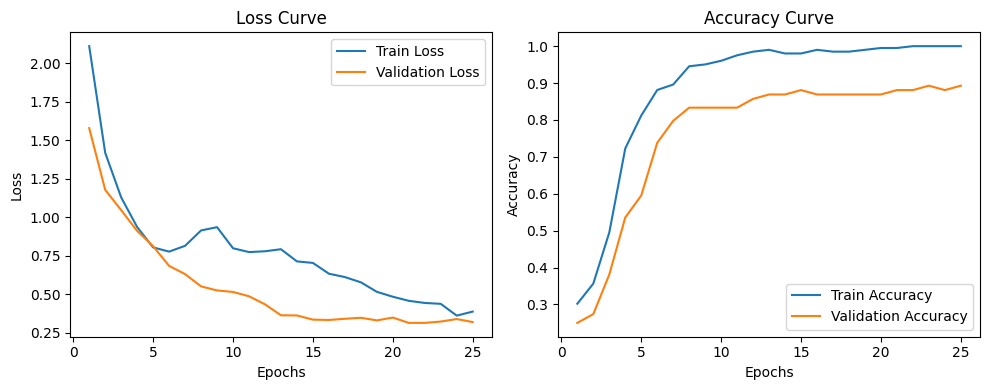

In [24]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(data['Epoch'], data['Train Loss'], label='Train Loss')
plt.plot(data['Epoch'], data['Validation Loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(data['Epoch'], data['Train Accuracy'], label='Train Accuracy')
plt.plot(data['Epoch'], data['Validation Accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### FixMatch Model Evaluation

In [18]:
best_checkpoint_path = f"{save_path_checkpoints}/fm_lb30_th80.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_accuracy, best_val_loss = validate(model, dataloader_valid_dataset, device)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

test_accuracy, test_loss = validate(model, dataloader_test_dataset, device)
print(f"Test Accuracy: {test_accuracy:.3f}")

<ipython-input-18-9fec25549cda>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path)


Best model (from epoch 23) - Validation Loss: 0.322, Validation Accuracy: 0.893
Test Accuracy: 0.964


In [19]:
def get_predictions_labels(model, dataloader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x, y = x.to(device), y.to(device)

            logits = model(x)
            predictions = torch.argmax(logits, dim=1).cpu().numpy()

            all_predictions.extend(predictions)
            all_labels.extend(y.cpu().numpy())

    return all_predictions, all_labels

test_predictions, test_labels = get_predictions_labels(model, dataloader_test_dataset, device)

class_names = [str(i) for i in range(total_class)]
val_classification_report = classification_report(test_labels, test_predictions, target_names=class_names)

print("Classification Report:")
print(val_classification_report)

def class_accuracy(predictions, labels, num_classes):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for pred, label in zip(predictions, labels):
        class_correct[label] += (pred == label)
        class_total[label] += 1

    class_acc = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_acc

class_acc = class_accuracy(test_predictions, test_labels, total_class)

for i, acc in enumerate(class_acc):
    print(f"Class {i}: Accuracy = {acc:.3f}")

print()
print("'Bacterial Leaf': 0, 'Dried Leaf': 1, 'Fungal Brown Spot': 2, 'Fungal Brown Spot': 3")

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        24
           1       1.00      1.00      1.00        11
           2       1.00      0.95      0.98        21
           3       0.96      0.93      0.95        28

    accuracy                           0.96        84
   macro avg       0.97      0.97      0.97        84
weighted avg       0.97      0.96      0.96        84

Class 0: Accuracy = 1.000
Class 1: Accuracy = 1.000
Class 2: Accuracy = 0.952
Class 3: Accuracy = 0.929

'Bacterial Leaf': 0, 'Dried Leaf': 1, 'Fungal Brown Spot': 2, 'Fungal Brown Spot': 3


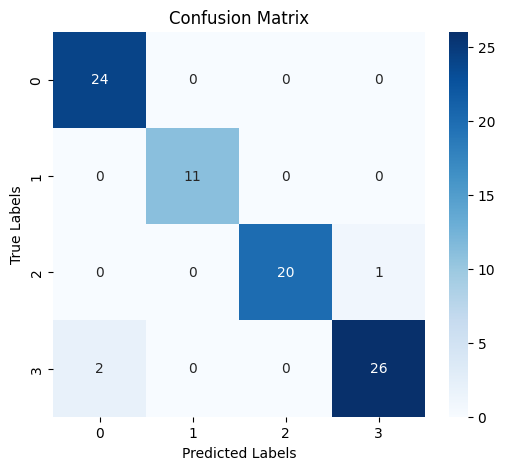

In [20]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, test_predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

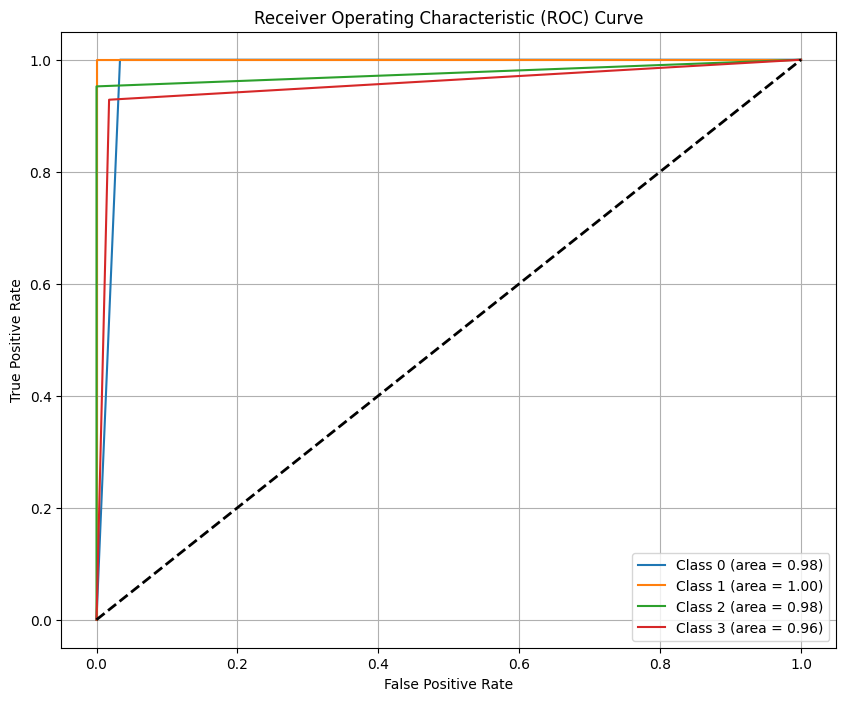

In [28]:
def plot_roc_curve(predictions, labels, num_classes):
    labels_binarized = label_binarize(labels, classes=list(range(num_classes)))
    predictions_binarized = label_binarize(predictions, classes=list(range(num_classes)))

    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(labels_binarized[:, i], predictions_binarized[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.show()

plot_roc_curve(test_predictions, test_labels, total_class)